In [22]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('vendor').resolve()))
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import scipy.fftpack
import glob
from utils import load_images, display_image, grayscale, normalize, display_grid_of_images, fft_dct
#for Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load and display release cell images
release_imgs = []

imgs = load_images('biofilm_data/release_cells/Untreated')
for i in range(len(imgs)):
    img = imgs[i]
    release_imgs.append(img)
for i in range(len(release_imgs)):
    release_imgs[i] = grayscale(release_imgs[i])
    
display_grid_of_images(release_imgs)

# Load and display biofilm images
biofilm_imgs = []

y_imgs = load_images('biofilm_data/biofilm/Untreated')
for i in range(len(y_imgs)):
    img = y_imgs[i]
    biofilm_imgs.append(img)
for i in range(len(biofilm_imgs)):
    biofilm_imgs[i] = grayscale(biofilm_imgs[i])
display_grid_of_images(biofilm_imgs)

ImportError: cannot import name 'fft_dct' from 'utils' (c:\Users\Meher\biofilm-image-analysis-1\utils.py)

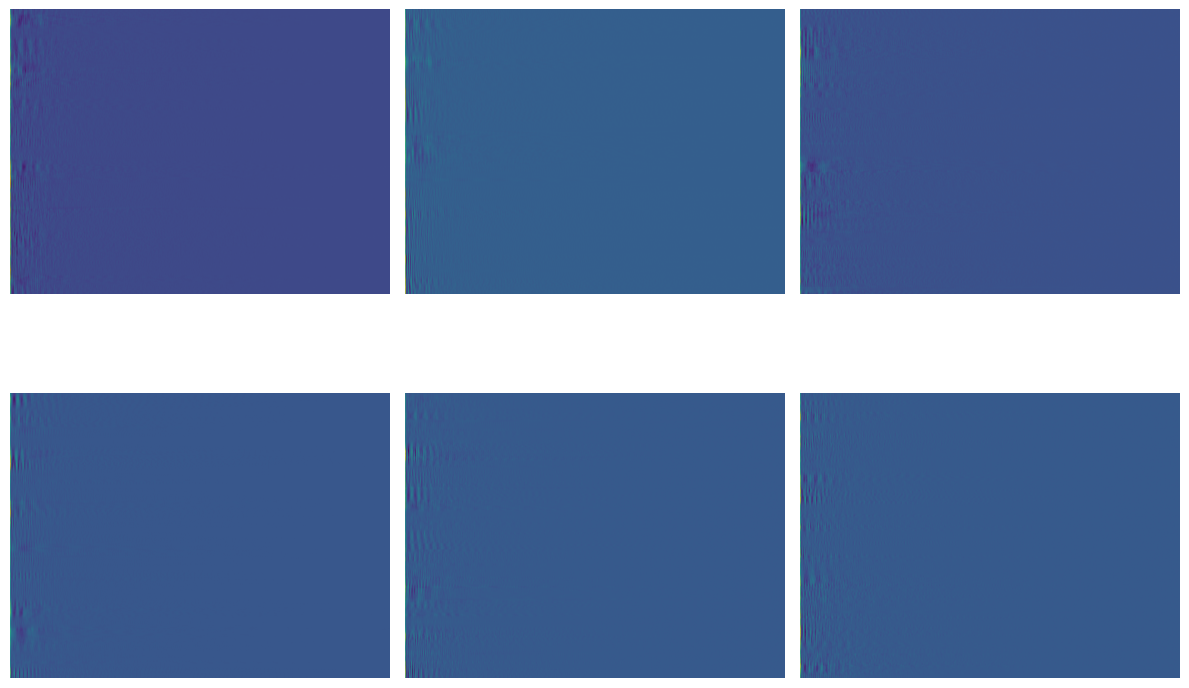

In [ ]:
for i in range(len(release_imgs)):
    release_imgs[i] = normalize(release_imgs[i])

dct_release_imgs = [scipy.fft.dct(release_imgs[i]) for i in range(len(release_imgs))]

display_grid_of_images(dct_release_imgs)

In [ ]:
dct_release_imgs_df = []
for i in range(len(dct_release_imgs)):
    df = pd.DataFrame(dct_release_imgs[i])
    dct_release_imgs_df.append(df)

#display head of dataframe
dct_release_imgs_df[0].head()
#flatten the dataframes
dct_release_imgs_flat = [df.values.flatten() for df in dct_release_imgs_df]



In [ ]:
#create the average release cell brightness of the biofilms\
biofilm_imgs_df = []
for i in range(len(biofilm_imgs)):
    df = pd.DataFrame(biofilm_imgs[i])
    biofilm_imgs_df.append(df)

avg_biofilm_brightness = []
for i in range(len(biofilm_imgs_df)):
    avg_brightness =biofilm_imgs_df[i].values.mean()
    avg_biofilm_brightness.append(avg_brightness)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dct_release_imgs_flat, avg_biofilm_brightness, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestRegressor(n_estimators=100, random_state=42)

RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)

# Compute MSE by hand
mse = 0
for y_true, y_prediction in zip(y_test, y_pred):
    mse += (y_true - y_prediction) ** 2
mse = mse / len(y_test)

print("MSE:", mse)

MSE: 639.0173951031871


In [ ]:
fft_dct(release_imgs[0])

NameError: name 'fft_dct' is not defined